<a href="https://colab.research.google.com/github/aritanaoya/keibaAI/blob/main/keibaAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import module

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
from urllib.request import urlopen
!pip3 install pickle5
import pickle5 as pickle
!pip install pandas-profiling==2.7.1
import pandas_profiling as pdp

# クラス定義

### DataProcessorクラス

訓練データと出馬表データを加工する抽象クラスです。DataProcessorクラスを、この次に定義するResultsクラスとShutubaTableクラスで継承して使います。

In [2]:
class DataProcessor:
    """    
    Attributes:
    ----------
    data : pd.DataFrame
        rawデータ
    data_p : pd.DataFrame
        preprocessing後のデータ
    data_h : pd.DataFrame
        merge_horse_results後のデータ
    data_pe : pd.DataFrame
        merge_peds後のデータ
    data_c : pd.DataFrame
        process_categorical後のデータ
    no_peds: Numpy.array
        merge_pedsを実行した時に、血統データが存在しなかった馬のhorse_id一覧
    """
    
    def __init__(self):
        self.data = pd.DataFrame()
        self.data_p = pd.DataFrame()
        self.data_h = pd.DataFrame()
        self.data_pe = pd.DataFrame()
        self.data_c = pd.DataFrame()
        
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        """
        馬の過去成績データから、
        n_samples_listで指定されたレース分の着順と賞金の平均を追加してdata_hに返す
        Parameters:
        ----------
        hr : HorseResults
            馬の過去成績データ
        n_samples_list : list, default [5, 9, 'all']
            過去何レース分追加するか
        """
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
        self.data_h.drop(['開催'], axis=1, inplace=True)    
	    
    def merge_peds(self, peds):
        """
        5世代分血統データを追加してdata_peに返す
        Parameters:
        ----------
        peds : Peds.peds_e
            Pedsクラスで加工された血統データ。
        """
	
        self.data_pe = \
            self.data_h.merge(peds, left_on='horse_id', right_index=True,
                                                             how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]\
            ['horse_id'].unique()
        if len(self.no_peds) > 0:
            print('scrape peds at horse_id_list "no_peds"')
            
    def process_categorical(self, le_horse, le_jockey, results_m):
        """
        カテゴリ変数を処理してdata_cに返す
        Parameters:
        ----------
        le_horse : sklearn.preprocessing.LabelEncoder
            horse_idを0始まりの整数に変換するLabelEncoderオブジェクト。
        le_jockey : sklearn.preprocessing.LabelEncoder
            jockey_idを0始まりの整数に変換するLabelEncoderオブジェクト。
        results_m : Results.data_pe
            ダミー変数化のとき、ResultsクラスとShutubaTableクラスで列を合わせるためのもの
        """
	
        df = self.data_pe.copy()
        
        #ラベルエンコーディング。horse_id, jockey_idを0始まりの整数に変換
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        #horse_id, jockey_idをpandasのcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        #そのほかのカテゴリ変数をpandasのcategory型に変換してからダミー変数化
        #列を一定にするため
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])
        
        self.data_c = df

### Resultsクラス

訓練に使うレース結果データを加工するクラス


In [3]:
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
        
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        """
        レース結果データをスクレイピングする関数
        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト
        Returns:
        ----------
        race_results_df : pandas.DataFrame
            全レース結果データをまとめてDataFrame型にしたもの
        """

        #race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id
                #メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]

                html = requests.get(url)
                html.encoding = "EUC-JP"
                soup = BeautifulSoup(html.text, "html.parser")

                #天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                    + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ["芝", "ダート"]:
                        df["race_type"] = [text] * len(df)
                    if "障" in text:
                        df["race_type"] = ["障害"] * len(df)
                    if "m" in text:
                        df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
                    if text in ["良", "稍重", "重", "不良"]:
                        df["ground_state"] = [text] * len(df)
                    if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                        df["weather"] = [text] * len(df)
                    if "年" in text:
                        df["date"] = [text] * len(df)

                #馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/horse")}
                )
                for a in horse_a_list:
                    horse_id = re.findall(r"\d+", a["href"])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
                    "a", attrs={"href": re.compile("^/jockey")}
                )
                for a in jockey_a_list:
                    jockey_id = re.findall(r"\d+", a["href"])
                    jockey_id_list.append(jockey_id[0])
                df["horse_id"] = horse_id_list
                df["jockey_id"] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
                time.sleep(1)
            #存在しないrace_idを飛ばす
            except IndexError:
                continue
            #wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            #Jupyterで停止ボタンを押した時の対処
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    #前処理    
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x:1 if x<4 else 0)

        # 性齢を性と年齢に分ける
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df["体重"] = df["馬体重"].str.split("(", expand=True)[0]
        df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1]
	
        #errors='coerce'で、"計不"など変換できない時に欠損値にする
        df['体重'] = pd.to_numeric(df['体重'], errors='coerce')
        df['体重変化'] = pd.to_numeric(df['体重変化'], errors='coerce')

        # 単勝をfloatに変換
        df["単勝"] = df["単勝"].astype(float)
	# 距離は10の位を切り捨てる
        df["course_len"] = df["course_len"].astype(float) // 100

        # 不要な列を削除
        df.drop(["タイム", "着差", "調教師", "性齢", "馬体重", '馬名', '騎手', '人気', '着順'],
                axis=1, inplace=True)

        df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")
        
        #開催場所
        df['開催'] = df.index.map(lambda x:str(x)[4:6])

        self.data_p = df
    
    #カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

### ShutubaTableクラス

予測に使う出馬表データを加工するクラスです。
ここで出馬表も取得しています

In [4]:
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    df["weather"] = [text] * len(df)
                if text in ["良", "稍重", "重"]:
                    df["ground_state"] = [text] * len(df)
                if '不' in text:
                    df["ground_state"] = ['不良'] * len(df)
                # 2020/12/13追加
                if '稍' in text:
                    df["ground_state"] = ['稍重'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        return cls(data)
             
    #前処理            
    def preprocessing(self):
        df = self.data.copy()
        
        df["性"] = df["性齢"].map(lambda x: str(x)[0])
        df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df["馬体重(増減)"] != '--']
        df["体重"] = df["馬体重(増減)"].str.split("(", expand=True)[0].astype(int)
        df["体重変化"] = df["馬体重(増減)"].str.split("(", expand=True)[1].str[:-1]
        # 2020/12/13追加：増減が「前計不」などのとき欠損値にする
        df['体重変化'] = pd.to_numeric(df['体重変化'], errors='coerce')
        
        df["date"] = pd.to_datetime(df["date"])
        
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)
        
        df['開催'] = df.index.map(lambda x:str(x)[4:6])

        # 使用する列を選択
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather','race_type',
        'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
       '体重', '体重変化', '開催']]
        
        self.data_p = df.rename(columns={'枠': '枠番'})

### HorseResultsクラス

馬の過去成績データを保持するクラスです。


In [5]:
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過', '開催', '距離']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        """
        馬の過去成績データをスクレイピングする関数
        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト
        Returns:
        ----------
        horse_results_df : pandas.DataFrame
            全馬の過去成績データをまとめてDataFrame型にしたもの
        """

        #horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = 'https://db.netkeiba.com/horse/' + horse_id
                df = pd.read_html(url)[3]
                #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
                if df.columns[0]=='受賞歴':
                    df = pd.read_html(url)[4]
                df.index = [horse_id] * len(df)
                horse_results[horse_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる        
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])

        return horse_results_df
    
    def preprocessing(self):
        df = self.horse_results.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)

        df["date"] = pd.to_datetime(df["日付"])
        df.drop(['日付'], axis=1, inplace=True)
        
        #賞金のNaNを0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        #1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)
        
        #レース展開データ
        #n=1: 最初のコーナー位置, n=4: 最終コーナー位置
        def corner(x, n):
            if type(x) != str:
                return x
            elif n==4:
                return int(re.findall(r'\d+', x)[-1])
            elif n==1:
                return int(re.findall(r'\d+', x)[0])
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        #開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        #race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        #距離は10の位を切り捨てる
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        #インデックス名を与える
        df.index.name = 'horse_id'
        
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner', 'final_corner',
                            'first_to_rank', 'first_to_final','final_to_rank']
    
    #n_samplesレース分馬ごとに平均する
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        #過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].\
                sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be >0')
        
	#集計して辞書型に入れる
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean()\
            .add_suffix('_{}R'.format(n_samples))
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])\
                [self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date']==date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id',
                             right_index=True, how='left')
        for column in ['course_len','race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], 
                                        left_on=['horse_id', column],
                                        right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
        return merged_df

#開催場所をidに変換するための辞書型
place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

#レースタイプをレース結果データと整合させるための辞書型
race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

### Pedsクラス

血統データを保持するクラスです。

In [6]:
class Peds:
    def __init__(self, peds):
        self.peds = peds
        self.peds_e = pd.DataFrame() #after label encoding and transforming into category
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        """
        血統データをスクレイピングする関数
        Parameters:
        ----------
        horse_id_list : list
            馬IDのリスト
        Returns:
        ----------
        peds_df : pandas.DataFrame
            全血統データをまとめてDataFrame型にしたもの
        """

        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = "https://db.netkeiba.com/horse/ped/" + horse_id
                df = pd.read_html(url)[0]

                #重複を削除して1列のSeries型データに直す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()
                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')

        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

### Returnクラス

取得した払い戻し表データを、（レースID, 勝った馬番, 払戻金）の形に加工します。

In [7]:
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        """
        払い戻し表データをスクレイピングする関数
        Parameters:
        ----------
        race_id_list : list
            レースIDのリスト
        Returns:
        ----------
        return_tables_df : pandas.DataFrame
            全払い戻し表データをまとめてDataFrame型にしたもの
        """

        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = "https://db.netkeiba.com/race/" + race_id

                #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
                #そのため、改行コードを文字列brに変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')
                dfs = pd.read_html(html)

                #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
                df = pd.concat([dfs[1], dfs[2]])

                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break

        #pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        return return_tables_df
    
    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1,2]]
        wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1,2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
	
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
        wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
        return_ = umaren[2].rename('return')  
        df = pd.concat([wins, return_], axis=1)        
        return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

### ModelEvaluatorクラス

モデルを評価用クラス

In [33]:
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.rt = Return.read_pickle([return_tables_path])
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
    
    #3着以内に入る確率を予測。出馬表のデータを入れるときはdrop_tansho=Falseにする。
    def predict_proba(self, X, drop_tansho=False):
        if drop_tansho:
            proba = pd.Series(self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index)
        else:
            proba = pd.Series(self.model.predict_proba(X)[:, 1], index=X.index)
        if self.std:
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    #0か1かを予測
    def predict(self, X, threshold=0.5):
        y_pred = self.predict_proba(X)
        return [0 if p<threshold else 1 for p in y_pred]
    
    def score(self, y_true, X):
        return roc_auc_score(y_true, self.predict_proba(X))
    
    def feature_importance(self, X, n_display=20):
        importances = pd.DataFrame({"features": X.columns, 
                                    "importance": self.model.feature_importances_})
        return importances.sort_values("importance", ascending=False)[:n_display]
    
    def pred_table(self, X, threshold=0.5, bet_only=True):
        pred_table = X.copy()[['馬番', '単勝']]
        pred_table['pred'] = self.predict(X, threshold)
        if bet_only:
            return pred_table[pred_table['pred']==1][['馬番', '単勝']]
        else:
            return pred_table
        
    def fukusho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df['win_{}'.format(i)]==df['馬番']]['return_{}'.format(i)].sum()
        return_rate = (n_bets*100 + money) / (n_bets*100)
        return n_bets, return_rate, None, None
    
    def tansho_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.sample_df = df
        
        #回収率の標準偏差を計算
        std = ((df['win'] == df['馬番'])*df['return'])\
            .groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['win']==df['馬番']])
        money += df[df['win']==df['馬番']]['return'].sum()
        return_rate = (n_bets*100 + money) / (n_bets*100)
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, X, threshold=0.5):
        #モデルによって「賭ける」と判断された馬たち
        pred_table = self.pred_table(X, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        #払い戻し表にpred_tableをマージ
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        #self.sample_df = df
        
        bet_money = (1 / pred_table['単勝']).sum()
        
        #回収率の標準偏差を計算
        std = ((df['win'] == df['馬番']).astype(int)).groupby(level=0).sum().std() \
            * np.sqrt(n_races) / bet_money
        
        #単勝適正回収値を計算
        n_hits = len(df.query('win == 馬番'))
        return_rate = n_hits / bet_money
        
        return n_bets, return_rate, n_hits, std
    
    def umaren_return(self, X, threshold=0.5):
        pred_table = self.pred_table(X, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds), 2)
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']])\
                .issubset(set(preds['馬番']))
        return_rate = (self.umaren.index.map(hit).values * self.umaren['return']).sum() \
            / (n_bets * 100)
        return n_bets, return_rate, None, None

# データ加工・前処理



### データ加工

まずはResultsクラス内のpreprocessing関数で、着順を0or1に直したり不要な列を削除したりしています。

In [10]:
#pickleのバージョンを修正
with open('results.pickle', "rb") as fh:
  data = pickle.load(fh)
data.to_pickle('results.pickle')
#pickleの読み込み
r = Results.read_pickle(['results.pickle'])
r.preprocessing()
r.data_p.info() #jupyterで出力

<class 'pandas.core.frame.DataFrame'>
Index: 47876 entries, 202001010101 to 202010020812
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   枠番            47876 non-null  int64         
 1   馬番            47876 non-null  int64         
 2   斤量            47876 non-null  float64       
 3   単勝            47876 non-null  float64       
 4   course_len    47876 non-null  float64       
 5   weather       47876 non-null  object        
 6   race_type     47876 non-null  object        
 7   ground_state  47876 non-null  object        
 8   date          47876 non-null  datetime64[ns]
 9   horse_id      47876 non-null  object        
 10  jockey_id     47876 non-null  object        
 11  rank          47876 non-null  int64         
 12  性             47876 non-null  object        
 13  年齢            47876 non-null  int64         
 14  体重            47876 non-null  int64         
 15  体重変化          47876 non

次に、馬の直近5レース、9レース、全レースの過去成績の平均を列に加えます。DataProcessorクラスから継承したmerge_horse_results関数を使います。引数にはHorseResultsクラスのオブジェクトと何走分を考えるかのリストを入れます。

In [10]:
!unzip horse_results.zip

Archive:  horse_results.zip
  inflating: horse_results.pickle    


In [11]:
#pickleのバージョンを修正
with open('horse_results.pickle', "rb") as fh:
  data = pickle.load(fh)
data.to_pickle('horse_results.pickle')
#pickleの読み込み
hr = HorseResults.read_pickle(['horse_results.pickle'])
r.merge_horse_results(hr, n_samples_list=[5, 9, 'all'])
r.data_h.info() #jupyterで出力

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

,枠番,馬番,斤量,単勝,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,rank,性,年齢,体重,体重変化,着順_5R,賞金_5R,着差_5R,first_corner_5R,final_corner_5R,first_to_rank_5R,first_to_final_5R,final_to_rank_5R,着順_course_len_5R,賞金_course_len_5R,着差_course_len_5R,first_corner_course_len_5R,final_corner_course_len_5R,first_to_rank_course_len_5R,first_to_final_course_len_5R,final_to_rank_course_len_5R,着順_race_type_5R,賞金_race_type_5R,着差_race_type_5R,first_corner_race_type_5R,final_corner_race_type_5R,first_to_rank_race_type_5R,first_to_final_race_type_5R,final_to_rank_race_type_5R,...,着順_開催_9R,賞金_開催_9R,着差_開催_9R,first_corner_開催_9R,final_corner_開催_9R,first_to_rank_開催_9R,first_to_final_開催_9R,final_to_rank_開催_9R,着順_allR,賞金_allR,着差_allR,first_corner_allR,final_corner_allR,first_to_rank_allR,first_to_final_allR,final_to_rank_allR,着順_course_len_allR,賞金_course_len_allR,着差_course_len_allR,first_corner_course_len_allR,final_corner_course_len_allR,first_to_rank_course_len_allR,first_to_final_course_len_allR,final_to_rank_course_len_allR,着順_race_type_allR,賞金_race_type_allR,着差_race_type_allR,first_corner_race_type_allR,final_corner_race_type_allR,first_to_rank_race_type_allR,first_to_final_race_type_allR,final_to_rank_race_type_allR,着順_開催_allR,賞金_開催_allR,着差_開催_allR,first_corner_開催_allR,final_corner_開催_allR,first_to_rank_開催_allR,first_to_final_開催_allR,final_to_rank_開催_allR
202001010101,6,6,54.0,16.0,18.0,曇,芝,良,2020-07-25,2018101626,01170,1,牝,2,438,4,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202001010101,2,2,54.0,1.9,18.0,曇,芝,良,2020-07-25,2018105193,05339,1,牡,2,510,0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202001010101,3,3,54.0,1.8,18.0,曇,芝,良,2020-07-25,2018104800,01032,1,牡,2,482,-6,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202001010101,1,1,52.0,22.2,18.0,曇,芝,良,2020-07-25,2018102410,01176,0,牝,2,442,0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202001010101,4,4,54.0,55.7,18.0,曇,芝,良,2020-07-25,2018100828,01116,0,牡,2,426,-8,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


次に5世代分の血統データを追加するのですが、merge_horse_resultsと同様に、継承したDataProcessorクラスのmerge_peds関数を使います。

In [12]:
#pickleのバージョンを修正
with open('peds_results.pickle', "rb") as fh:
  data = pickle.load(fh)
data.to_pickle('peds_results.pickle')
#pickleの読み込み
p = Peds.read_pickle(['peds_results.pickle'])
p.encode()
print(p.peds_e)
r.merge_peds(p.peds_e)
r.data_pe.head() #jupyterで出力

           peds_0 peds_1 peds_2 peds_3  ... peds_58 peds_59 peds_60 peds_61
2018101626    256   2162    166    373  ...      87     827    1321    3146
2018105193    341   4892    154    239  ...     247     673     931     306
2018104800    292   6072    145    399  ...     391     543     562     930
2018102410    227   7440    176    259  ...      19      91     607    2439
2018100828    449   3302    141    294  ...     154     937     204     316
...           ...    ...    ...    ...  ...     ...     ...     ...     ...
2018109169    293   2342     75    107  ...     486    1140    1056    2816
2017104830    285   3964    183    285  ...     175     668     414     663
2017101519    348   5414    141    328  ...     147     202     966    1512
2018106621    438   6351    139    378  ...     288     910     581    2443
2014102720    189   2535    145    405  ...     244     611    1093    2660

[11702 rows x 62 columns]


,枠番,馬番,斤量,単勝,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,rank,性,年齢,体重,体重変化,着順_5R,賞金_5R,着差_5R,first_corner_5R,final_corner_5R,first_to_rank_5R,first_to_final_5R,final_to_rank_5R,着順_course_len_5R,賞金_course_len_5R,着差_course_len_5R,first_corner_course_len_5R,final_corner_course_len_5R,first_to_rank_course_len_5R,first_to_final_course_len_5R,final_to_rank_course_len_5R,着順_race_type_5R,賞金_race_type_5R,着差_race_type_5R,first_corner_race_type_5R,final_corner_race_type_5R,first_to_rank_race_type_5R,first_to_final_race_type_5R,final_to_rank_race_type_5R,...,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
202001010101,6,6,54.0,16.0,18.0,曇,芝,良,2020-07-25,2018101626,01170,1,牝,2,438,4,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,0.0,1.5,9.0,9.0,-2.0,0.0,-2.0,...,87,236,280,567,354,976,1130,3629,8,6,80,56,66,30,149,186,85,129,182,226,135,33,266,348,48,89,66,264,144,124,57,335,64,374,73,488,87,827,1321,3146
202001010101,2,2,54.0,1.9,18.0,曇,芝,良,2020-07-25,2018105193,05339,1,牡,2,510,0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,2.0,280.0,0.0,3.0,1.0,1.0,2.0,-1.0,...,87,66,286,335,345,708,555,1589,37,40,20,3,57,91,81,38,48,37,137,142,23,193,175,131,48,89,26,239,153,265,184,417,79,334,181,620,247,673,931,306
202001010101,3,3,54.0,1.8,18.0,曇,芝,良,2020-07-25,2018104800,01032,1,牡,2,482,-6,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,2.0,280.0,0.4,3.0,3.0,1.0,0.0,1.0,...,147,146,346,637,125,678,265,1550,8,2,6,50,51,88,54,120,24,21,157,123,87,124,285,376,50,119,116,113,148,327,376,164,156,192,90,675,391,543,562,930
202001010101,1,1,52.0,22.2,18.0,曇,芝,良,2020-07-25,2018102410,01176,0,牝,2,442,0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,5.0,70.0,1.4,1.0,1.0,-4.0,0.0,-4.0,...,88,141,73,571,120,578,77,1252,8,6,80,56,40,68,17,68,48,105,131,44,130,115,0,252,50,126,92,160,28,273,52,652,36,107,9,51,19,91,607,2439
202001010101,4,4,54.0,55.7,18.0,曇,芝,良,2020-07-25,2018100828,01116,0,牡,2,426,-8,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,12.0,0.0,4.4,9.0,10.0,-3.0,-1.0,-2.0,...,87,66,286,335,207,435,83,973,25,21,56,60,92,74,10,162,25,123,180,228,87,68,86,236,48,89,26,239,153,265,184,417,110,232,454,420,154,937,204,316


最後にカテゴリ変数の処理として、次の2つのことをします。

1. horse_idとjockey_idを血統データと同様にPandasのcategory型に変更する
2. 天気、レース種別、馬場の状態、馬の性別をダミー変数化

レース結果データについては、Resultsクラス内でprocess_categorical関数をオーバーライドします。この時、出馬表データのhorse_idとjockey_idを処理する時のために、Resultsクラス内のle_horseとle_jockeyという変数に、LabelEncoderオブジェクトを保持しておきます。ダミー変数化のところがなぜ複雑になっているかは、次の出馬表データの加工のところで説明します。

In [13]:
r.process_categorical() #r.le_horse, r.le_jockeyに対応関係が保存される

In [14]:
r.data_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47876 entries, 202001010101 to 202009060812
Columns: 186 entries, 枠番 to 性_セ
dtypes: category(64), datetime64[ns](1), float64(99), int64(6), uint8(16)
memory usage: 48.9+ MB


# モデルの作成・学習

### データの分割

In [26]:
from sklearn.model_selection import TimeSeriesSplit,train_test_split
train, valid = train_test_split(r.data_c)



optunaのインポート

In [ ]:
!pip install optuna
import optuna.integration.lightgbm as lgb_o

### optunaを用いてモデルチューニング

In [ ]:
#データセットを作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

params = {
    'objective': 'binary', #今回は0or1の二値予測なのでbinaryを指定
    'random_state': 100
}

#チューニング実行
lgb_clf_o = lgb_o.train(params, lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10)

In [29]:
lgb_clf_o.params #jupyterで出力

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.41600000000000004,
 'feature_pre_filter': False,
 'lambda_l1': 0.007186367653938558,
 'lambda_l2': 0.9684995728607215,
 'min_child_samples': 25,
 'num_leaves': 10,
 'objective': 'binary',
 'random_state': 100}

### LightGBMによる学習

In [36]:
train, test = train_test_split(r.data_c)

#説明変数と目的変数に分ける。dateはこの後不要なので省く。
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
#2021/3/12追加： テストデータの単勝オッズはシミュレーション時に使用するので残しておく
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.41600000000000004, feature_pre_filter=False,
               importance_type='split', lambda_l1=0.007186367653938558,
               lambda_l2=0.9684995728607215, learning_rate=0.1, max_depth=-1,
               min_child_samples=25, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=10, objective='binary',
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
import lightgbm as lgb
from sklearn import datasets
from sklearn.metrics import accuracy_score


class lgbModelExtractionCallback(object):
    """lightgbm.cv() から学習済みモデルを取り出すためのコールバックに使うクラス

    NOTE: 非公開クラス '_CVBooster' に依存しているため将来的に動かなく恐れがある
    """

    def __init__(self):
        self._model = None

    def __call__(self, env):
        # _CVBooster の参照を保持する
        self._model = env.model

    def _assert_called_cb(self):
        if self._model is None:
            # コールバックが呼ばれていないときは例外にする
            raise RuntimeError('callback has not called yet')

    @property
    def boosters_proxy(self):
        self._assert_called_cb()
        # Booster へのプロキシオブジェクトを返す
        return self._model

    @property
    def raw_boosters(self):
        self._assert_called_cb()
        # Booster のリストを返す
        return self._model.boosters

    @property
    def best_iteration(self):
        self._assert_called_cb()
        # Early stop したときの boosting round を返す
        return self._model.best_iteration


def lgb_clf(data):

    # デモ用にデータセットを分割する
    train,test = train_test_split(data,shuffle=False)
    
    #説明変数と目的変数に分ける。dateはこの後不要なので省く。単勝オッズも学習時には使わない。
    X_train = train.drop(['rank', 'date', '単勝'], axis=1)
    y_train = train['rank']
    X_test = valid.drop(['rank', 'date', '単勝'], axis=1)
    y_test = valid['rank']

    # LightGBM 用のデータセット表現に直す
    lgb_train = lgb.Dataset(X_train, y_train)

    # 学習済みモデルを取り出すためのコールバックを用意する
    extraction_cb = ModelExtractionCallback()
    callbacks = [
        extraction_cb,
    ]

    # データセットを 5-Fold CV で学習する
    lgbm_params = {
        'objective': 'multiclass',
        'num_class': 3,
    }
    # NOTE: 一般的には返り値の内容 (交差検証の結果) を確認する
    lgb.cv(lgbm_params,
           lgb_train,
           num_boost_round=1000,
           early_stopping_rounds=10,
           nfold=5,
           shuffle=True,
           stratified=True,
           seed=42,
           callbacks=callbacks,
           )

    # コールバックのオブジェクトから学習済みモデルを取り出す
    proxy = extraction_cb.boosters_proxy
    boosters = extraction_cb.raw_boosters
    best_iteration = extraction_cb.best_iteration

    # 各モデルの推論結果を Averaging する場合
    y_pred_proba_list = proxy.predict(X_test,
                                      num_iteration=best_iteration)
    y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
    y_pred = np.argmax(y_pred_proba_avg, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print('Averaging accuracy:', accuracy)

    # 各モデルで個別に推論する場合
    for i, booster in enumerate(boosters):
        y_pred_proba = booster.predict(X_test,
                                       num_iteration=best_iteration)
        y_pred = np.argmax(y_pred_proba, axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        print('Model {0} accuracy: {1}'.format(i, accuracy))

# モデル評価

In [37]:
#時系列に4分割
tss = TimeSeriesSplit(4)
folds = tss.split(X_train)

lgb_train = lgb.Dataset(X_train, y_train)
params_with_metric = {'metric': 'l2', 'verbose': -1}
lgb.cv(params_with_metric, lgb_train, num_boost_round=10, folds=folds, stratified=False, verbose_eval=False)

{'l2-mean': [0.16567044954613516,
  0.16334578566380423,
  0.16154202394036232,
  0.1600080628642524,
  0.15884288591707194,
  0.15783179689292784,
  0.1570714944685341,
  0.1564795387605451,
  0.15596531694535848,
  0.15555733682727846],
 'l2-stdv': [0.0030009625187071842,
  0.003013216207125663,
  0.0029900761043812583,
  0.002968329166546558,
  0.0029127993720824774,
  0.0029229355015782427,
  0.0028640476132432142,
  0.0030000000134815844,
  0.0030609754682390275,
  0.0030345035234052246]}

# 回収率シミュレーション

In [143]:
#pickleのバージョンを修正
with open('return_tables.pickle', "rb") as fh:
  data = pickle.load(fh)
data.to_pickle('return_tables.pickle')
#pickleの読み込み
rt = Return.read_pickle(['return_tables.pickle'])
rt.fukusho #jupyterで表示

,win_0,win_1,win_2,return_0,return_1,return_2
202001010101,6,2,0,490,130,0
202001010102,4,14,13,130,170,300
202001010103,2,6,12,130,120,380
202001010104,13,2,10,900,170,640
202001010105,2,5,0,410,170,0
...,...,...,...,...,...,...
202010020808,2,9,1,130,130,380
202010020809,10,4,5,140,140,170
202010020810,6,2,5,190,220,370
202010020811,8,9,2,160,110,210


### gain関数

回収率を計算する関数

In [144]:
def gain(return_func, X, n_samples=100, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = 1 * i / n_samples + min_threshold * (1-(i/n_samples))
        n_bets, return_rate, n_hits, std = return_func(X, threshold)
        if n_bets > 2:
            gain[n_bets] = {'return_rate': return_rate, 
                            'n_hits': n_hits,
                            'std': std}
    return pd.DataFrame(gain).T

### 回収率シミュレーション

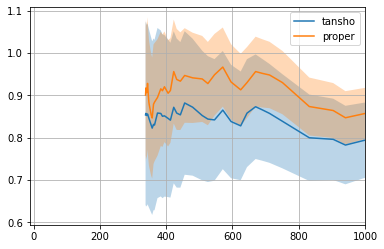

In [150]:
#ModelEvaluatorクラスのオブジェクトを作成
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

#単勝適正回収値＝払い戻し金額が常に一定になるように賭けた場合の回収率
g_proper = gain(me.tansho_return_proper, X_test)
#単勝の回収率
g_tansho = gain(me.tansho_return, X_test)

#プロット
plt.fill_between(g_tansho.index, y1=g_tansho['return_rate']-g_tansho['std'],
                 y2=g_tansho['return_rate']+g_tansho['std'],
                 alpha=0.3)
plt.plot(g_tansho.index, g_tansho['return_rate'], label='tansho')
plt.fill_between(g_proper.index, y1=g_proper['return_rate']-g_proper['std'],
                 y2=g_proper['return_rate']+g_proper['std'],
                 alpha=0.3)
plt.plot(g_proper.index, g_proper['return_rate'], label='proper')

plt.xlim(-10, 1000)
plt.legend()
plt.grid()

# 予測

In [34]:
#目的変数は「3着以内に入ったかどうか」の0or1データを持った'rank'
X = r.data_c.drop(['rank', 'date', '単勝'], axis=1)
y = r.data_c['rank']

#予測モデル作成&学習
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X.values, y.values)

#自作したModelEvaluatorクラスのオブジェクトを作成
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

FileNotFoundError: ignored

### 出馬表の加工

予測で使う出馬表データの加工です。出馬表は他のデータと違って、レース直前にその都度スクレイピングすることになります。

In [ ]:
#予測したいrace_idを指定してスクレイピング
race_id_list = ['202106030811']
st = ShutubaTable.scrape(race_id_list, '2021/04/18')
#前処理
st.preprocessing()

#馬の過去成績データの追加。新馬はNaNが追加される
st.merge_horse_results(hr)
#5世代分の血統データの追加
st.merge_peds(p.peds_e)

#scrape peds at horse_id_list "no_peds"と表示された場合
#peds_new = Peds.scrape(st.no_peds)
#peds.to_pickle('peds_h.pickle') #pedsを更新する前にバックアップ
#peds = update_data(peds, peds_new)
#peds.to_pickle('peds.pickle')
#p = Peds.read_pickle(['peds.pickle'])
#p.encode()
#st.merge_peds(p.peds_e)

#カテゴリカルデータへ加工
st.process_categorical(r.le_horse, r.le_jockey, r.data_pe)
st.data_c

### 予測

In [156]:
#馬が勝つ確率を予測
X = st.data_c.drop(['date'], axis=1)
pred = me.predict_proba(st.data_c.drop(['date'], axis=1))

#予測結果を表に結合
pred_table = st.data_c[['馬番']].copy()
print(st.data[['馬名','馬番']])
pred_table['pred'] = pred
#確率が高い順に出力
pred_table.sort_values('pred', ascending=False)

                     馬名  馬番
202106030811   アドマイヤハダル   1
202106030811   ルーパステソーロ   2
202106030811  ステラヴェローチェ   3
202106030811  イルーシヴパンサー   4
202106030811  ヴィクティファルス   5
202106030811    ヨーホーレイク   6
202106030811    エフフォーリア   7
202106030811    ダノンザキッド   8
202106030811       ラーゴム   9
202106030811  シュヴァリエローズ  10
202106030811  ディープモンスター  11
202106030811  ワールドリバイバル  12
202106030811   タイトルホルダー  13
202106030811   アサマノイタズラ  14
202106030811     グラティアス  15
202106030811   レッドベルオーブ  16


,馬番,pred
202106030811,8,1.000000
202106030811,13,0.713512
202106030811,4,0.712268
202106030811,15,0.706173
202106030811,6,0.692809
202106030811,1,0.649460
202106030811,5,0.641208
202106030811,7,0.638010
202106030811,3,0.627899
202106030811,9,0.593083
